# Run on Large Molecules
We have the solvation energies for a few dozen large molecules in different solvents. We are going to use them as a test set.

Given the need to scale to large molecules, we assess two different strategies: a model which predict solvation energy given the entire fingerprint of a molecule and a model which uses atomic-level contributions.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from jcesr_ml.benchmark import dielectric_constants, load_benchmark_data
from jcesr_ml.mpnn import set_custom_objects, run_model, GraphModel
from sklearn.neighbors import NearestNeighbors
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model
from scipy.stats import sem
from tqdm import tqdm
from multiprocessing import Pool
from functools import partial
from util import compute_dist_from_training_entry
import pickle as pkl
import pandas as pd
import numpy as np
import os

Using TensorFlow backend.
/lus/theta-fs0/projects/CSC249ADCD08/solvation-energy-ml/env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/lus/theta-fs0/projects/CSC249ADCD08/solvation-energy-ml/env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/lus/theta-fs0/projects/CSC249ADCD08/solvation-energy-ml/env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)

Model to evaluate

In [2]:
set_custom_objects()
models = {
    'molecule': load_model(os.path.join('..', 'mpnn', 'networks', 'dielectric-constant-softplus', '117232-entries',
                                '128-nodes', '16384-batch_size', '1.00e-04-learning_rate', 'best_model.h5')),
    'atomic-level': load_model(os.path.join('..', 'mpnn', 'networks', 'dielectric-constant-softplus-atomic-contrib', '117232-entries',
                                '128-nodes', '16384-batch_size', '1.00e-04-learning_rate', 'best_model.h5'))
}
with open(os.path.join('..', 'mpnn', 'networks', 'dielectric-constant-softplus-atomic-contrib', 'converter.pkl'), 'rb') as fp:
    conv = pkl.load(fp)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


/lus/theta-fs0/projects/CSC249ADCD08/solvation-energy-ml/env/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


## Load in the Datasets
They are stored in our `data/output` directory

In [3]:
data = pd.read_json(os.path.join('..', 'data', 'output', f'pdb_data.json'), lines=True)
data['source'] = 'pdb'

Add in the QM9 holdout set

In [4]:
train_data, test_data = load_benchmark_data()
test_data['source'] = 'QM9'
test_data.rename(columns={'smiles_0': 'smiles', 'n_atom': 'n_atoms'}, inplace=True)
data = pd.concat((data, test_data), ignore_index=True, sort=False)

Some datasets include both the SMILES and composition in the SMILES string

In [5]:
data['smiles'] = data['smiles'].apply(lambda x: x.split('\t')[0])

There is some overlap between the datasets

In [6]:
data.drop_duplicates('smiles', inplace=True)
print(f'Loaded {len(data)} unique molecules')

Loaded 13217 unique molecules


In [7]:
data['source'].value_counts()

QM9    13026
pdb      191
Name: source, dtype: int64

See how many have molecular motifs we have not yet observed.

We first change the tokenizers used in the preprocessor out of training mode, so 
that they will assign unseen motifs a label of `1`. 
This will result in the DL model using a randomly-initialized embedding for that atom or bond type,
in contrast to the learned embeddings for all other grops

In [8]:
conv.atom_tokenizer.train = conv.bond_tokenizer.train = False

In [9]:
def has_unseen_types(smiles: str) -> str:
    """Determine whether a molecule contains atom or bond types that
    were not included in the training set
    
    Args:
        smiles (str): SMILES string of a molecule
    Returns:
        (str) Label of whether it has new bonds or atom types
    """
    features = conv.construct_feature_matrices(smiles)
    
    new_atoms = any(features['atom'] == 1)
    new_bonds = any(features['bond'] == 1)
    
    if not (new_atoms or new_bonds):
        return 'none'
    elif new_atoms and not new_bonds:
        return 'atoms'
    elif not new_atoms and new_bonds:
        return 'bonds'
    else:
        return 'atoms+bonds'

In [10]:
data['unseen_types'] = data['smiles'].apply(has_unseen_types)

In [11]:
data['unseen_types'].value_counts()

none     13209
bonds        8
Name: unseen_types, dtype: int64

In [12]:
set(conv.bond_tokenizer.unknown)

{"(rdkit.Chem.rdchem.BondType.DOUBLE, True, False, ['N', 'N'])",
 "(rdkit.Chem.rdchem.BondType.SINGLE, False, False, ['F', 'N'])",
 "(rdkit.Chem.rdchem.BondType.SINGLE, False, False, ['N', 'N'])",
 "(rdkit.Chem.rdchem.BondType.SINGLE, False, False, ['O', 'O'])",
 "(rdkit.Chem.rdchem.BondType.SINGLE, True, False, ['N', 'N'])"}

*Finding*: 8 of our molecules have unseen bonding types, which include conjugated N=N bonds annd O-O single bonds.

## Evaluate Model on this Data
Run it for all solvents for which we have data for all solvents

In [13]:
sol_cols = [x for x in data.columns if x.startswith('sol_') and not data[x].isnull().any()]
print(f'Found {len(sol_cols)} solvation energy columns')

Found 3 solvation energy columns


Drop all unnecessary columns

In [14]:
data = data[['smiles'] + sol_cols + ['source', 'n_heavy_atoms', 'n_atoms', 'name', 'unseen_types']]

Modify the converter to produce entries for these solvents

In [15]:
conv.dielectric_cnsts = [dielectric_constants[c] for c in sol_cols]

Run the model and store the errors

In [16]:
y_preds = dict((name, run_model(model, conv, data['smiles'])) for name, model in models.items())

In [17]:
output = {}
for name, y_pred in y_preds.items():
    errors = (y_pred - data[sol_cols])
    errors.rename(mapper=lambda x: x + '_error', axis=1, inplace=True)
    err_cols = errors.columns
    for n, v in zip([f'{x}_pred' for x in sol_cols], y_pred.T):
        errors[n] = v
    output[name] = pd.concat((data, errors), ignore_index=False, axis=1)

Plot the total error histogram

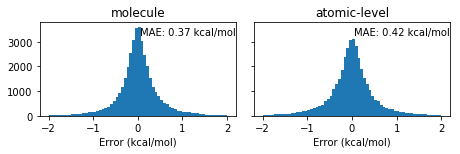

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(6.5, 2.25), sharey=True)

for ax, (name, subset) in zip(axs, output.items()):
    errors = np.ravel(subset[err_cols])
    ax.hist(errors, bins=64, range=(-2, 2))
    ax.set_xlabel('Error (kcal/mol)')
    ax.text(1, 0.95, f'MAE:{np.abs(errors).mean() : .2f} kcal/mol', 
            ha='right', va='top', transform=ax.transAxes)
    ax.set_title(name)

fig.tight_layout()

Break it down by source and size

In [19]:
def mean_abs_error(x):
    return np.abs(x).mean()
def mean_abs_error_sem(x):
    return sem(np.abs(x))
def mean_abs_deviation(x):
    return np.abs(x - np.mean(x)).mean()
funcs = [mean_abs_error, mean_abs_error_sem, len]

In [20]:
agg_funcs = dict((x, funcs) for x in err_cols)
agg_funcs.update(dict((x, [mean_abs_deviation, np.median]) for x in sol_cols))

/lus/theta-fs0/projects/CSC249ADCD08/solvation-energy-ml/env/lib/python3.6/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/lus/theta-fs0/projects/CSC249ADCD08/solvation-energy-ml/env/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


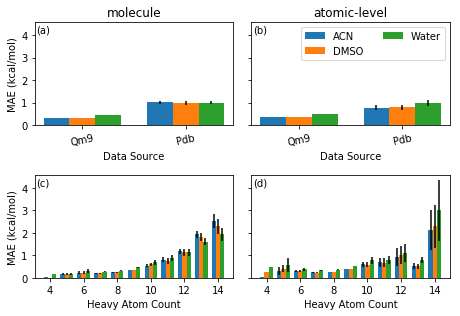

In [21]:
fig, aaxs = plt.subplots(2, 2, figsize=(6.5, 4.5), sharey=True)

# Loop over names
for ni, (axs, (name, subset)) in enumerate(zip(aaxs.T, output.items())):
    # Get the columns to include in the labels
    labels = []

    # Plot the dependence on source
    analysis = subset.groupby('source').agg(agg_funcs)
    x = np.arange(len(analysis))
    for i, c in enumerate(err_cols):
        mad = analysis[c[:-6]]['mean_abs_deviation']
        solvent = c.split("_")[1]
        label=solvent.capitalize() if solvent=='water' else solvent.upper()
        l = axs[0].bar(x - 0.25 + i * 0.25, analysis[c]['mean_abs_error'], yerr=analysis[c]['mean_abs_error_sem'],
                  width=0.25, align='center')
        labels.append((l, label))
    axs[0].set_xticks(x)
    axs[0].set_xticklabels(analysis.index.str.capitalize(), rotation=12)
    axs[0].set_xlabel('Data Source')

    # Plot the atom count dependence
    analysis = subset.query('n_heavy_atoms > 3').groupby('n_heavy_atoms').agg(agg_funcs)
    x = analysis.index.min() + np.arange(len(analysis))
    for i, c in enumerate(err_cols):
        mad = analysis[c[:-6]]['mean_abs_deviation']
        axs[1].bar(x - 0.25 + i * 0.25, analysis[c]['mean_abs_error'], yerr=analysis[c]['mean_abs_error_sem'],
                  width=0.25, align='center')
    axs[1].set_xlabel('Heavy Atom Count')

    axs[0].set_title(name)

for i, ax in enumerate(np.ravel(aaxs)):
    ax.text(0.01, 0.9, f'({chr(97+i)})', transform=ax.transAxes, ha='left')

for ax in aaxs[:, 0]:
    ax.set_ylabel('MAE (kcal/mol)')
    
aaxs[0, 1].legend(*zip(*labels), ncol=2, loc='upper right')

fig.tight_layout()
fig.savefig(os.path.join('figures', 'holdout-set-tests.png'), dpi=320)
fig.savefig(os.path.join('figures', 'holdout-set-tests.eps'))

Save a succinct summary of the non-QM9 predictions

## Compute Distance to Training Set
We want to compute the distance of each point in the test set to the nearest entries in the training 

### Molecular Fingerprint
Assess the distance based on the full molecular fingerprint

In [22]:
model = models['molecule']
data = output['molecule']

In [23]:
# reduce_atom_to_mol_5 is the layer that produces the molecular fingerprint
#  I found it by printing the summary (model.summary())
rep_model = GraphModel(inputs=model.inputs, outputs=model.get_layer('reduce_atom_to_mol_5').output)

In [ ]:
rep_model.save('molecule-rep-model.h5')

Compute the representations for the train and test sets

In [24]:
%%time
train_mols = run_model(rep_model, conv, train_data['smiles_0'], n_jobs=4)

CPU times: user 37min 47s, sys: 4min 36s, total: 42min 23s
Wall time: 1min 22s


In [25]:
%%time
test_mols = run_model(rep_model, conv, data['smiles'], n_jobs=4)

CPU times: user 4min 17s, sys: 31 s, total: 4min 48s
Wall time: 8.91 s


Compute the distance to the 64 closest neighbors

In [26]:
n_counts = [1, 2, 4, 8, 16, 32, 64]

In [27]:
%%time
dim_reduction = Pipeline([
    ('scale', MinMaxScaler()),
])
nn_computer = NearestNeighbors(n_neighbors=max(n_counts), n_jobs=-1).fit(dim_reduction.fit_transform(train_mols))
train_dists = nn_computer.kneighbors(dim_reduction.transform(test_mols))[0]

CPU times: user 6h 6min 57s, sys: 2.01 s, total: 6h 6min 59s
Wall time: 6min 44s


In [28]:
for n in n_counts:
    data[f'train_dist_{n}'] = train_dists[:, :n].mean(axis=1)

Plot the dependence of error on distance

Text(0, 0.5, 'Mean Error (kcal/mol)')

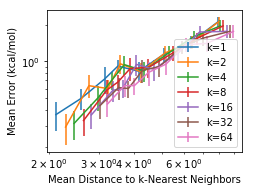

In [29]:
fig, ax = plt.subplots(figsize=(3.5, 2.6))

data['total_error'] = output['molecule'][err_cols].abs().mean(axis=1)
for n in n_counts:
    dist_col = f'train_dist_{n}'
    dist_mean, err_mean, err_sem = zip(*[(np.mean(s[dist_col]), np.mean(s['total_error']), sem(s['total_error'])) 
                                           for s in np.array_split(data.query('source != "QM9"').sort_values(dist_col), 8)])

    ax.errorbar(dist_mean, err_mean, yerr=err_sem, label=f'k={n}')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
ax.set_xlabel('Mean Distance to k-Nearest Neighbors')
ax.set_ylabel('Mean Error (kcal/mol)')

*Finding*: The relationship between distance and error seems clearest for k=64

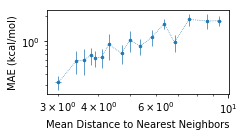

In [30]:
fig, ax = plt.subplots(figsize=(3.5, 2))

data['total_error'] = output['molecule'][err_cols].abs().mean(axis=1)
n=64
dist_col = f'train_dist_{n}'
dist_mean, dist_sem, err_mean, err_sem = zip(*[(np.mean(s[dist_col]), sem(s[dist_col]), np.mean(s['total_error']), sem(s['total_error'])) 
                                       for s in np.array_split(data.query('source != "QM9"').sort_values(dist_col), 16)])

ax.errorbar(dist_mean, err_mean, xerr=dist_sem, yerr=err_sem, label=f'k={n}', marker='o', markersize=2.5
            , linestyle=':', lw=0.7)
ax.set_xscale('log', basex=10)
ax.set_yscale('log')
ax.set_xlabel('Mean Distance to Nearest Neighbors')
ax.set_ylabel('MAE (kcal/mol)')
fig.tight_layout()
fig.savefig(os.path.join('figures', 'error-vs-distance.png'), dpi=320)
fig.savefig(os.path.join('figures', 'error-vs-distance.eps'))

*Finding*: There is indeed a clear relationship between MAE and the distance to the training set even for the larger molecules

Save the results

In [31]:
data.to_csv('molecule.csv', index=False)

Drop the large arrays from memory

In [32]:
del train_dists, train_mols, test_mols

### Atomic-Level Features
We define the distance between molecules as the average distance of each atomic representation

Get the atomic representation model

In [33]:
model = models['atomic-level']
data = output['atomic-level']

In [34]:
rep_model = GraphModel(inputs=model.inputs, outputs=model.get_layer('dense_65').input)
rep_model.output_shape

(None, 128)

In [1]:
rep_model.save('atomic-rep-model.h5')

NameError: name 'rep_model' is not defined

Measure the distances for all atoms in the training set. 

The dataset of the features of all atoms is too expensive to hold in memory at once.
So, we compute it in chunks

In [35]:
test_reps = run_model(rep_model, conv, data['smiles'], n_jobs=4)
test_reps = np.array_split(test_reps, data['n_atoms'].cumsum())[:-1]

In [36]:
train_dists = np.zeros((len(test_reps), max(n_counts))) + np.inf
for train_chunk in tqdm(np.array_split(train_data[['smiles_0', 'n_atom']], 4)):
    # Compute the molecular representation for this chunk
    train_reps = run_model(rep_model, conv, train_chunk['smiles_0'], n_jobs=4)
    train_reps = np.array_split(train_reps, train_chunk['n_atom'].cumsum())[:-1]
    
    # Compute the distances
    new_train_dists = np.zeros((len(test_reps), len(train_chunk)))
    with Pool(16) as pool:
        for i, mol_a in enumerate(test_reps):
            func = partial(compute_dist_from_training_entry, mol_a)
            dists = pool.map(func, train_reps)
            new_train_dists[i, :] = dists
            
    # Sort to get the top ones
    temp = np.hstack((train_dists, new_train_dists))
    temp.sort(axis=1)
    train_dists = temp[:, :max(n_counts)]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [17:35:39<00:00, 15834.86s/it]


In [37]:
for n in n_counts:
    data[f'train_dist_{n}'] = train_dists[:, :n].mean(axis=1)

As above, plot the error as a function of distance

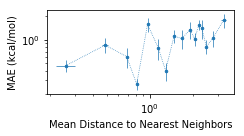

In [38]:
fig, ax = plt.subplots(figsize=(3.5, 2))

data['total_error'] = output['molecule'][err_cols].abs().mean(axis=1)
n=64
dist_col = f'train_dist_{n}'
dist_mean, dist_sem, err_mean, err_sem = zip(*[(np.mean(s[dist_col]), sem(s[dist_col]), np.mean(s['total_error']), sem(s['total_error'])) 
                                       for s in np.array_split(data.sort_values(dist_col), 16)])

ax.errorbar(dist_mean, err_mean, xerr=dist_sem, yerr=err_sem, label=f'k={n}', marker='o', markersize=2.5
            , linestyle=':', lw=0.7)
ax.set_xscale('log', basex=10)
ax.set_yscale('log')
ax.set_xlabel('Mean Distance to Nearest Neighbors')
ax.set_ylabel('MAE (kcal/mol)')
fig.tight_layout()

Save distances to disk

In [39]:
data.to_csv('atomic-fingerprints.csv', index=False)